# Reinforcement learning homework
---

Jordi Morera

### Homework 1: Simple parametric policies

Let $\phi : X x A \rightarrow \mathbb{R}^{d}$

Compute $\nabla_{\theta}log(\pi_{\theta}(a|x))$ for the Boltzmann policy:

$$
\pi_{\theta}(a | x)=\frac{e^{\theta^{\top} \phi(x, a)}}{\sum_{b} e^{\theta^{\top} \phi(x, b)}}
$$

*Answer:*

$$
\begin{array}{c}{\nabla_{\theta} \log \pi_{\theta}(a | x)=\nabla_{\theta} \log \frac{e^{\theta^{\top} \phi(x, a)}}{\sum_{b} e^{\theta^{\top} \phi(x, b)}}=\\\nabla_{\theta} \log e^{\theta^{\top} \phi(x, a)}-\nabla_{\theta} \log \sum_{b} e^{\theta^{\top} \phi(x, b)}=}\end{array}
$$

Computing the gradient

$$
\begin{array}{c}{{\phi(x, a)-\frac{1}{\sum_{b} e^{\theta^{\top} \phi(x, b)}}\sum_{b'} e^{\theta^{\top} \phi(x, b')}}=\\{\phi(x, a)-\sum_{b'} \frac{\exp \left(\theta^{\top} \phi(x, b')\right)}{\sum_{b} \exp \left(\theta^{\top} \phi\left(x, b)\right)\right)} \phi(x, b')}}\end{array}
$$

Finally obtaining 
$$
\begin{array}{c}{\nabla_{\theta}log(\pi_{\theta}(a|x)) = \phi(x, a)-\sum_{b} \pi_{\theta}(b|x) \phi(x, b)}\end{array}
$$

Which can be rewritten as

$$
\nabla_{\theta} \log \pi_{\theta}(a| x)=\phi(x, a)-\mathbb{E}_{\pi_{\theta}}[\phi(x, \cdot)]
$$

### Homework 2: Policy gradient in a simple MDP

Run a policy gradient algorithm with a Boltzmann policy using $\phi_i(x,a) = 𝟏_{(a=1)}$

*Answer:*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import copy
import itertools

from matplotlib import rcParams
rcParams['figure.figsize'] = 15,10

class Environment():
    def __init__(self, delta):
        self.p1 = 0.5
        self.p2 = 0.5 + delta
    
    def step(self, action):
        if action == 0:
            return np.random.binomial(1,self.p1)
        elif action == 1:
            return np.random.binomial(1,self.p2)
        else:
            raise ValueError("Action {} not correct".format(action))

class BoltzmannPolicy():
    def __init__(self):
        self.phi = np.identity(2)
        self.weights = [0.5,0.5]
        
    def evaluate(self):
        return np.exp(self.weights)/np.sum(np.exp(self.weights))
    
    def pick_action(self):
        return np.random.choice([0,1],p = self.evaluate())
    
    def eval_gradient(self,action):
        return self.phi[:,action] - self.phi @ self.evaluate()
                  
class TD0AC():
    "Temporal difference actor-critic algorithm with linear function aproximation"
    def __init__(self, delta, gamma, c, beta = 0.05, step_type = "fixed", seed = 1 ):
        self.env = Environment(delta)
        self.gamma = gamma
        self.policy = BoltzmannPolicy()
        self.seed = seed
        self.step_type = step_type
        self.delta = delta
        self.V_w = 0
        self.beta = beta
        
        if  step_type == 'fixed':
            self.alpha = lambda k : c
        elif step_type == 'lin_dec':
            self.alpha = lambda k : c/k
        elif step_type == 'quad_dec':
            self.alpha = lambda k : c/(k**2)
        elif step_type == 'sqrt_dec':
            self.alpha = lambda k : c/np.sqrt(k)
        else:
            raise ValueError("Step size type {} not correct".format(step_type))
        
        np.random.seed(seed)
    
    
    def train(self, train_steps):
                
        train_logs = []
        itr_logs = { 
            "train_step" : 0,
            "delta" : self.delta,
            "gamma" : self.gamma,
            "alpha" : self.alpha(1),
            "step_type" : self.step_type,
            "seed" : self.seed,
            "policy" : 0,
            "w1" : self.policy.weights[0],
            "w2" : self.policy.weights[1],
            "action" : 0,
            "reward" : 0,
            "cum_reward" : 0,
            "v_func" : self.V_w
        }
            
        rewards = []
        for i in range(train_steps): 

            # Each trajectory consistis in several steps of x, a, r, x'
            # Particularly, in this case, we have x'= x

            # Sample transition
            action = self.policy.pick_action()
            rewards.append(self.env.step(action))
            
            
            # Compute TD(0) error
            td_error = rewards[-1] + (self.gamma-1) * self.V_w


            # Policy update
            self.policy.weights +=  self.alpha(i+1)*\
                                    self.policy.eval_gradient(action)*\
                                    td_error
            
            # Value function weight update
            self.V_w += self.beta * td_error

            # Store training logs
            aux = { 
                "train_step" : i+1,
                "alpha" : self.alpha(i+1),
                "policy" : self.policy.evaluate()[1],
                "w1" : self.policy.weights[0],
                "w2" : self.policy.weights[1],
                "action" : action,
                "reward" : rewards[-1],
                "cum_reward" : np.sum(rewards),
                "v_func" : self.V_w
            }
            itr_logs.update(aux)
            train_logs.append(copy.deepcopy(itr_logs))
            
        return  pd.DataFrame(train_logs)

In [2]:
### Init params ###
train_steps = 5000
seeds = [2,3,5]

In [3]:
delta = 0.1
gamma = 0.4
c = 0.1

train_plot = pd.DataFrame()
ep_plot = pd.DataFrame()
for seed in seeds:
    reinf_alg = TD0AC(delta = delta, 
                          gamma = gamma,
                          c = c,
                          step_type = "fixed",
                          seed = seed)
    train_data = reinf_alg.train(train_steps)
    train_plot = train_plot.append(train_data, ignore_index= True)

Path of w1 and w2 to convergence 

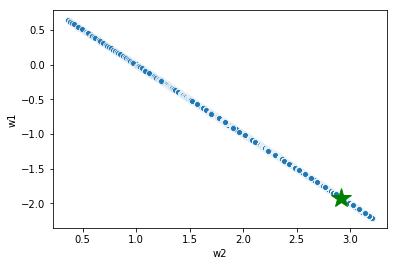

In [4]:
sns.scatterplot(x = 'w2',y = 'w1', data = train_plot)
plt.plot(train_plot.w2.tail(1),train_plot.w1.tail(1) ,'*', markersize=20, color='green')

Text(0.5, 1.0, 'Policy weights')

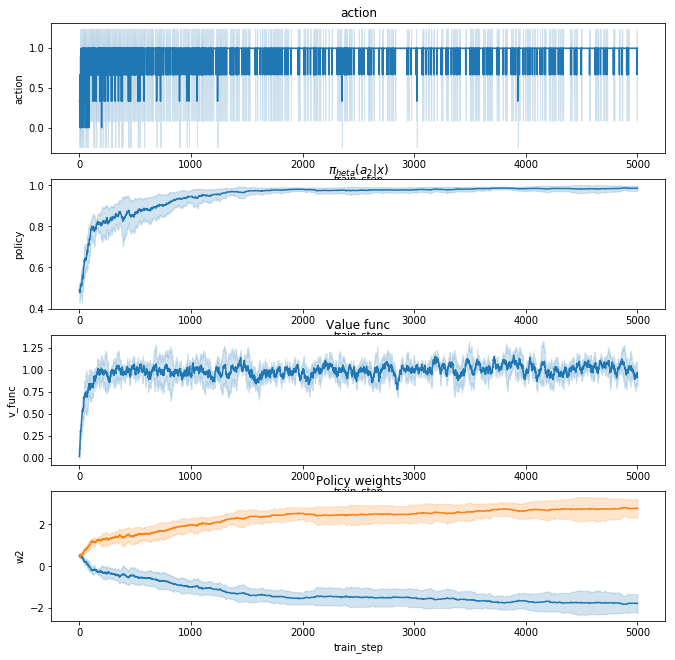

In [5]:
fig,axes = plt.subplots(4,1,figsize=(11, 11))
sns.lineplot(x = 'train_step', y = 'action', ci = 'sd', data = train_plot, ax = axes[0]).set_title("action")
sns.lineplot(x = 'train_step', y = 'policy', ci = 'sd', data = train_plot, ax = axes[1]).set_title("$\pi_{\theta}(a_{2}|x)$")
sns.lineplot(x = 'train_step', y = 'v_func', ci = 'sd', data = train_plot, ax = axes[2]).set_title("Value func")
sns.lineplot(x = 'train_step', y = 'w1', ci = 'sd', data = train_plot, ax = axes[3]).set_title("Policy weights")
sns.lineplot(x = 'train_step', y = 'w2', ci = 'sd', data = train_plot, ax = axes[3]).set_title("Policy weights")

*Note that the policy values are plotted together with the sd over different seeds. Policy function values cannot be higher than 1 or lower than 0, however, mean +- sd can be higher than 1. The main objective is to illustrate the volatility of the mesure.*

#### 2.1  How does the choice of $\gamma$ influence the behavior of the algorithm?

*Answer:*

In [6]:
delta = 0.4
c = 0.1

gammas = [0.1,0.3,0.5,0.7,0.9]
train_plot = pd.DataFrame()

for seed,gamma in itertools.product(seeds,gammas):
    reinf_alg = TD0AC(delta = delta, 
                          gamma = gamma,
                          c = c,
                          step_type = "fixed",
                          seed = seed)
    train_data = reinf_alg.train(train_steps)
    train_plot = train_plot.append(train_data, ignore_index= True)

Text(0.5, 1.0, 'Value func')

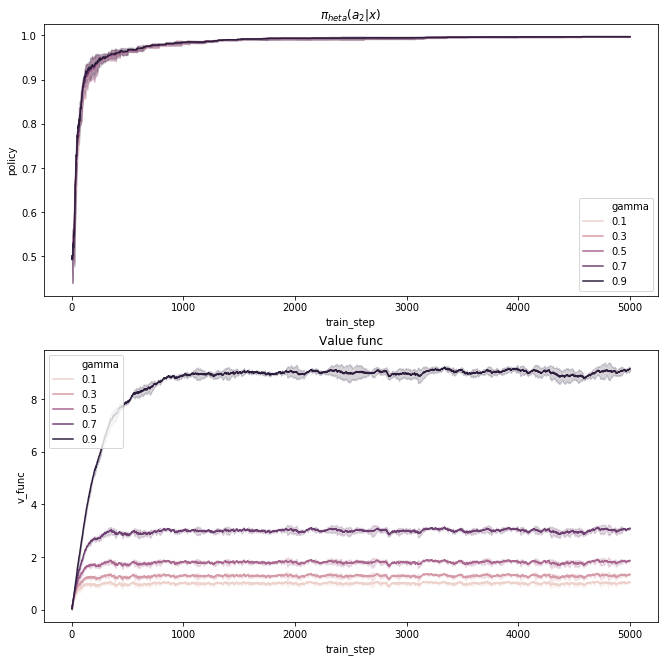

In [7]:
fig,axes = plt.subplots(2,1,figsize=(11, 11))

sns.lineplot(x = 'train_step', y = 'policy', ci = 'sd', hue = 'gamma',  legend ='full',data = train_plot, ax = axes[0]).set_title("$\pi_{\theta}(a_{2}|x)$")
sns.lineplot(x = 'train_step', y = 'v_func', ci = 'sd', hue = 'gamma',  legend ='full',data = train_plot, ax = axes[1]).set_title("Value func")

The gamma parameter controls the discounting factor of the future discounted reward. The higher is gamma, the more rewards from future episodes we consider to take an action. This leads to more volatile policy function. 

#### 2.2 Fix 𝛾 = 0.99 and Δ = 0.05, and consider the step sizes $\frac{\alpha_{k}}{\sqrt{k}} ,\frac{\alpha_{k}}{k}, \text { and },\frac{\alpha_{k}}{k^{2}}$ for various choices of 𝑐. Plot $\pi_{\theta_{k}}(a_{2}|x)$ as a function of 𝑘.

*Answer:*

In [8]:
step_types = ['fixed' , 'lin_dec' , 'quad_dec' ,'sqrt_dec']

gamma = 0.99
delta = 0.05
c = 0.2

# c = {'fixed' : 0.1 ,
#      'lin_dec' : 100,
#      'quad_dec': 0.1,
#      'sqrt_dec' :10
# }




train_plot = pd.DataFrame()

for seed,step_type in itertools.product(seeds,step_types):
    reinf_alg = TD0AC(delta = delta, 
                          gamma = gamma,
                          c = c,
                          step_type = step_type,
                          seed = seed)
    train_data = reinf_alg.train(train_steps)
    train_plot = train_plot.append(train_data, ignore_index= True)

Text(0.5, 1.0, '$\\pi_{\theta}(a_{2}|x)$')

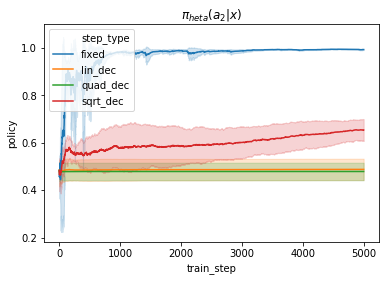

In [9]:
sns.lineplot(x = 'train_step', 
             y = 'policy', 
             ci = 'sd', 
             hue = 'step_type', 
             data = train_plot, legend = 'full').set_title("$\pi_{\theta}(a_{2}|x)$")

We find that, for delta small, only fixed step size manages to get the right answer 100% of the times. The other step sizes, for a given initial c, some seeds converge to the wrong policy.

#### 2.3. Pick the best of these step sizes and plot $\pi_{\theta_{k}}(a_{2}|x)$ as a function of 𝑘 for Δ ∈ {0.01,0.05,0.1,0.5}.

*Answer:*

In [10]:
step_type = 'fixed'

deltas = [0.01,0.05,0.1,0.5]

train_steps = 1000

gamma = 0.99
c =0.2


train_plot = pd.DataFrame()

for seed,delta in itertools.product(seeds,deltas):
    reinf_alg = TD0AC(delta = delta, 
                          gamma = gamma,
                          c = c,
                          step_type = step_type,
                          seed = seed)
    train_data = reinf_alg.train(train_steps)
    train_plot = train_plot.append(train_data, ignore_index= True)

Text(0.5, 1.0, '$\\pi_{\theta}(a_{2}|x)$')

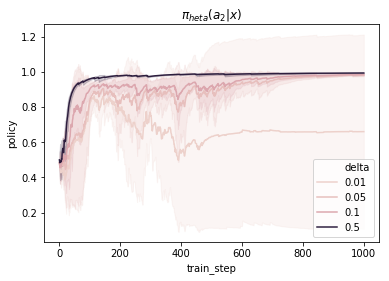

In [11]:
sns.lineplot(x = 'train_step', 
             y = 'policy', 
             ci = 'sd', 
             hue = 'delta', 
             data = train_plot, legend = 'full').set_title("$\pi_{\theta}(a_{2}|x)$")

We observe faster convergence for big deltas.

### Homework 3 : Basic bandit algorithms

Consider the bandit problem from Homework 2.

#### 3.1. Implement UCB and plot its total reward after 𝑇 = 10000 rounds as a function of Δ.

*Answer:*

In [12]:
class UCB():
    def __init__(self, delta, beta):
        self.env = Environment(delta)
        self.beta = beta
        self.means = np.zeros(2)
        self.counter =np.zeros(2)
        self.delta = delta
        
        
        #Force one trial to avoid 0 division
        for action in range(2):
            reward = self.env.step(action)
            self.update_mean(action,reward)
        
    def choose_arm(self):
        return np.argmax(self.means + np.sqrt(self.beta*np.log(np.sum(self.counter))/self.counter))

    def update_mean(self,action,reward):
        
        self.counter[action] += 1
        self.means[action] = self.means[action] +  1/(1+self.counter[action])*(reward-self.means[action])
        
    def train(self, iterations):
        
        
        train_logs = pd.DataFrame()
        tot_rew = 0
        
        for i in range(iterations):
            
            action = self.choose_arm()
            reward = self.env.step(action)
            self.update_mean(action,reward)
            
            tot_rew += reward
            
#             train_it_log = pd.DataFrame([[i, action, reward, self.delta, self.means, self.counter]],
#                                          columns = ["it", "action", "reward","delta", "means", "counter"]) 
            
#             train_logs = train_logs.append(train_it_log, ignore_index = True)
            
        return tot_rew
        

Text(0.5, 1.0, 'UCB total reward as a function of delta')

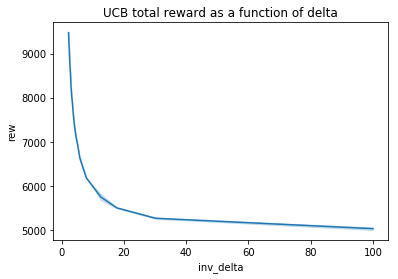

In [13]:
beta = 1
deltas = np.linspace(0.01,0.45,20)

rews_UCB = []
for seed,delta in itertools.product(seeds,deltas):
    reinf_alg = UCB(delta,beta)
    rew = reinf_alg.train(10000)        
    _ = { 'seed':seed, 'inv_delta': 1/delta, 'rew':rew}
    rews_UCB.append(copy.deepcopy(_))
        
    
res_UCB = pd.DataFrame(rews_UCB)  
sns.lineplot(x = 'inv_delta', y = 'rew', ci = 'sd', data = res_UCB, legend = 'full').set_title("UCB total reward as a function of delta")


#### 3.3. Implement 𝜀-greedy with 𝜀 = 𝑐/𝑡 for various choices of c. Plot its total reward after 𝑇 = 10000 rounds as a function of Δ.

*Answer:*

In [14]:
class eps_greedy():
    def __init__(self, delta, c, seed =1):
        self.env = Environment(delta)
        self.eps = lambda t: c/t
        self.means = np.zeros(2)
        self.counter =np.zeros(2)
        self.delta = delta
        
        np.random.seed(seed)
                
        #Force one trial to avoid 0 division
        for action in range(2):
            reward = self.env.step(action)
            self.update_mean(action,reward)
        
    def choose_arm(self, it):
        
        if np.random.uniform() > self.eps(it):
            return np.random.randint(2)
        
        else:
            return np.argmax(self.means)

    def update_mean(self,action,reward):
        
        self.counter[action] += 1
        self.means[action] = self.means[action] +  1/(1+self.counter[action])*(reward-self.means[action])
        
    def train(self, iterations):
        
        
        train_logs = pd.DataFrame()
        tot_rew = 0
        
        for i in range(iterations):
            
            action = self.choose_arm(i+1)
            reward = self.env.step(action)
            self.update_mean(action,reward)
            
            tot_rew += reward
            
#             train_it_log = pd.DataFrame([[i, action, reward, self.delta, self.means, self.counter]],
#                                          columns = ["it", "action", "reward","delta", "means", "counter"]) 
            
#             train_logs = train_logs.append(train_it_log, ignore_index = True)
            
        return tot_rew

Text(0.5, 1.0, 'Eps greedy total reward as a function of delta')

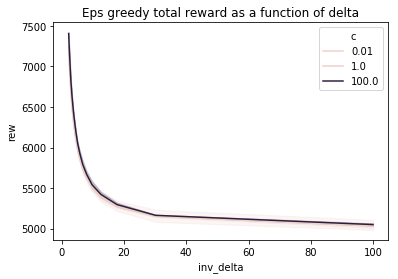

In [15]:
cs = [0.01,1,100]
deltas = np.linspace(0.01,0.45,20)

rews_eps = []

for seed,c,delta in itertools.product(seeds,cs,deltas):
    reinf_alg = eps_greedy(delta,c, seed)
    rew = reinf_alg.train(10000)        
    _ = { 'seed':seed,'c':c, 'inv_delta': 1/delta, 'rew':rew}
    rews_UCB.append(copy.deepcopy(_))

    
res_eps = pd.DataFrame(rews_UCB)  
sns.lineplot(x = 'inv_delta', y = 'rew', ci = 'sd',hue ='c', data = res_eps, legend = 'full').set_title("Eps greedy total reward as a function of delta")

#### 3.3. Contrast the newly obtained results with those obtained for policy gradient methods. Which algorithm do you think is the best and why.

*Answer:*

In [16]:
seeds = [3]
train_steps = 10000
gamma = 0.99
c =0.2
deltas = np.linspace(0.01,0.45,10)


train_plot_AC = pd.DataFrame()

for seed,delta in itertools.product(seeds,deltas):
    reinf_alg = TD0AC(delta = delta, 
                          gamma = gamma,
                          c = c,
                          step_type = step_type,
                          seed = seed)
    train_data = reinf_alg.train(train_steps)
    train_plot_AC = train_plot_AC.append(train_data, ignore_index= True)


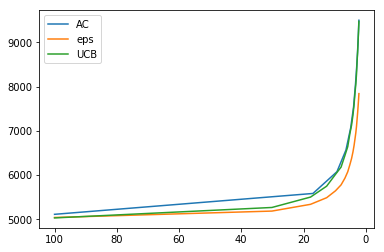

In [17]:
train_plot_AC["inv_delta"] = train_plot_AC["delta"].apply(lambda x: 1/x )
AC_plot = train_plot_AC[["cum_reward","inv_delta"]].groupby('inv_delta').max()
eps_plot = res_eps[["rew","inv_delta"]].groupby('inv_delta').mean()
UCB_plot = res_UCB[["rew","inv_delta"]].groupby('inv_delta').mean()

plt.plot(AC_plot.index,AC_plot["cum_reward"], label = "AC")
plt.plot(eps_plot.index,eps_plot["rew"], label = "eps")
plt.plot(UCB_plot.index,UCB_plot["rew"], label = "UCB")

plt.gca().invert_xaxis()
plt.legend()